# Gesture Recognition
In this group project, we are going to build a 3DConv/CNN+RNN model that will be able to predict the 5 gestures correctly.

In [1]:
## Checking the GPU configuration
!nvidia-smi 

Tue Oct 11 02:28:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:1C:00.0 Off |                  Off |
| 33%   26C    P8     5W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Import generic libraries 
import numpy as np
import matplotlib.pyplot as plt
import os
from imageio import imread
from skimage.transform import resize
import datetime
import pathlib

In [3]:
#import libraries required for different Model architectures and Model building
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from keras import layers
from tensorflow import keras
import tensorflow as tf

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
tf.random.set_seed(30)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### In this block, we read the folder names for training and validation. 

***We are going to split val data into val and test data. We have kept 50% of validation data set of images folders belonging to each class separate for testing the model***

In [12]:
train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines()[0:50])
test_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines()[50:100])

num_train_sequences = len(train_doc)
num_test_sequences=len(test_doc)
num_val_sequences = len(val_doc)
print('Number of train sequences',num_train_sequences)
print('Number of test sequences',num_test_sequences)
print('Number of val sequences',num_val_sequences)

Number of train sequences 663
Number of test sequences 50
Number of val sequences 50


In [13]:
train_path ='/datasets/Project_data/train'
test_path='/datasets/Project_data/val'
val_path = '/datasets/Project_data/val'


Name of Directory is: /datasets/Project_data/val/WIN_20180926_17_28_32_Pro_Thumbs_Up_new


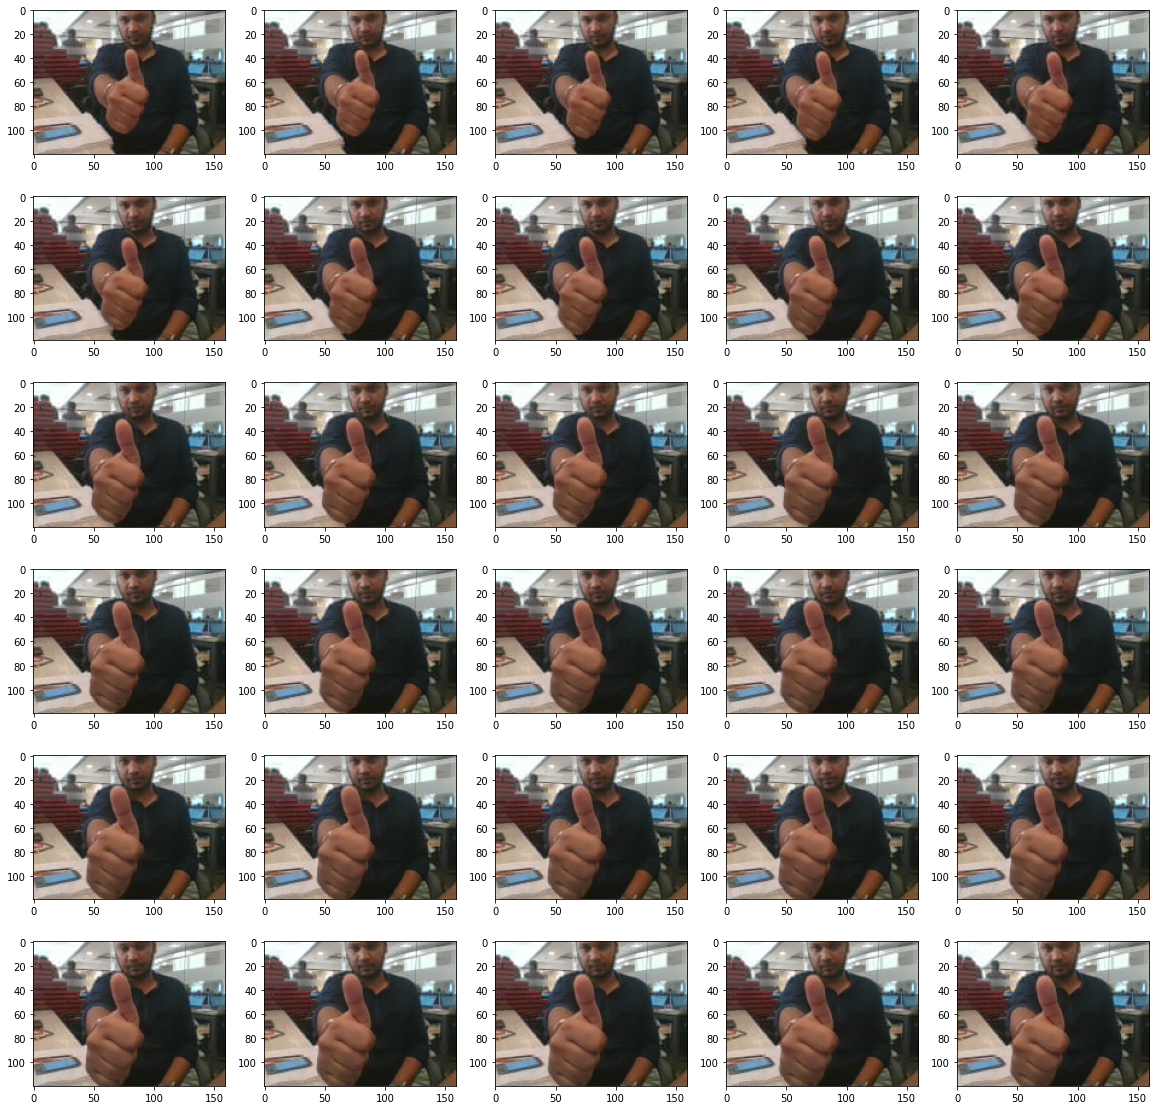

In [35]:
#Inspect the images in a folder
image_list = []
folder_dir = test_path+'/'+(test_doc[0]).split(';')[0]
print("Name of Directory is:",folder_dir)
for images in sorted(os.listdir(folder_dir)):
        image_list.append(folder_dir+'/'+images)
# #Set fig Size
plt.figure(figsize=(20,20))
# # Iterative Visualization of images of each class
for i in range(len(image_list)):
  plt.subplot(6,5,i+1)
  image = plt.imread(image_list[i])
  plt.imshow(image)

In [ ]:
#In Python, the glob module is used to retrieve files/pathnames matching a specified pattern
image_count_train = len(list(pathlib.Path(train_path).glob('*/*.png')))
print(image_count_train)
image_count_test = len(list(pathlib.Path(val_path).glob('*/*.png')))
print(image_count_test)

19890
3000


### **Reusable Functions**

## Generator
This is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have experimented with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

**We will experiment with below parameters**
- Batch size
- Image dimensions
- Number of epochs
- Frame sequences

Recommendations:

- If GPU size is 2GB, Try batch size: 16,8
- If GPU size is 4GB, Try batch size: 16,8
- If GPU size is 6GB, Try batch size: 32,16,8
- If GPU size is above 6GB, Try batch size: 64,32,16,8

We have images in 2 different sizes available, 120 * 160 and 360 * 360. Hence 
we will experiment with 120 * 120 and 100 * 100 and 64 * 64 sizes.

*We have 30 frames in each sequence category*. 
*But to reduce the computation complexity, we will try to reduce the number of frames in sequence*.
*We will take only those frames which describes the intended action accurately*. 

In [61]:
# Parameters for Generator with default values
BATCH_SIZE=32
image_height=128
image_width=128
IMG_IDX=list(range(0,30,1)) 
frames_from_seq=len(IMG_IDX)

In [62]:
# Parameters for Model
NUM_ClASSES=5
NUM_EPOCHS=15
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(2,2,2)
STRIDE=1
OPTIMISER="Adam"

In [63]:
def display_generator_params():
  print("Batch Size : ",BATCH_SIZE)
  print("image height:",image_height,"image width:",image_width)
  print("img index :",IMG_IDX)
  print("frames from sequence:",frames_from_seq)

In [64]:
def display_model_params():
    print ('# epochs =', NUM_EPOCHS)
    print ('# channels =', CHANNELS)
    print ('# Optimizer =', OPTIMISER)

In [65]:
def prepare_batch(source,t,this_batch,extra_items=0):
  img_idx=IMG_IDX
  batch_size=BATCH_SIZE
  seqlen = extra_items if extra_items !=0 else batch_size
  #print("For debug-Seqlen:",seqlen)

  batch_data = np.zeros((seqlen,len(img_idx),image_height,image_width,3))                    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((seqlen,NUM_ClASSES))                                                        # batch_labels is the one hot representation of the output. this is because in batch labels 4,3,2 ,1,0, model tend to give more importance to label 4
  for folder in range(seqlen):
    imgs = sorted(os.listdir(source+'/'+ t[folder + (this_batch*batch_size)].split(';')[0])) # The csv file is ; separated.Order of images matters for identifying the action
    for idx,item in enumerate(img_idx):
       image = imread(source+'/'+ t[folder + (this_batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
       image=resize(image,(image_height,image_width) )
       batch_data[folder,idx,:,:,0] = (image[:,:,0])/255                                       #Resizing Channel 1 of image (As it is RGB Image)
       batch_data[folder,idx,:,:,1] = (image[:,:,1])/255                                       #Resizing Channel 2 of image (As it is RGB Image)
       batch_data[folder,idx,:,:,2] = (image[:,:,2])/255                                       #Resizing Channel 3 of image (As it is RGB Image)
    batch_labels[folder, int(t[folder + (this_batch*batch_size)].strip().split(';')[2])] = 1    
  return batch_data,batch_labels

In [66]:
def generator(source_path, folder_list):
    batch_size=BATCH_SIZE
    print( 'Source path = ', source_path)
    display_generator_params()
    while True:
        t = np.random.permutation(folder_list)           # Choose folder list in random order
        num_batches =len(t) // batch_size                # Calculate the number of required batches
        #print("For debug-Number of batches:",num_batches)
        for batch in range(num_batches):                 # Iterate over batches
            #print("For debug-batch:",batch)
            batch_data, batch_labels= prepare_batch(source_path,t,batch,0)
            yield batch_data, batch_labels               # You yield the batch_data and the batch_labels
        
        extra=len(t)%batch_size                          # Get the remaining items that could not make a full batch   
        #print("For debug-Extra:",extra)
        if extra != 0:
          batch_data, batch_labels= prepare_batch(source_path,t,batch,extra)
          yield batch_data, batch_labels
                    

In [67]:
#Function for ploting and visualising evaulation results
def plot(history):
      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
      axes[0].plot(history.history['loss'])   
      axes[0].plot(history.history['val_loss'])
      axes[0].legend(['loss','val_loss'])

      axes[1].plot(history.history['categorical_accuracy'])   
      axes[1].plot(history.history['val_categorical_accuracy'])
      axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here we make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [68]:
#function to Add 1 3D convolution hidden Layers and 1 Max pool layers , 1 optional Batch normalization layer.
def conv3D_block(model,filters,kernel_size):
  model.add(Conv3D(filters,kernel_size, padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling3D(pool_size=(2, 2, 2)))
  return model


In [69]:
def define_model(filters=FILTERS,Kernel_size=KERNEL_SIZE,Num_Conv_Block=4):
        model = Sequential()
        model.add(Conv3D(filters, (3, 3, 3), padding='same',
                 input_shape=(frames_from_seq,image_height,image_width,CHANNELS)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        # Adding required number of Convolution blocks 
        for count in range(1,Num_Conv_Block):
            filters=filters*2
            model=conv3D_block(model,filters,Kernel_size)

        #Adding flatten and Dense Layers
        model.add(Flatten())
        model.add(Dense(filters,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(filters/2,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))

        model.add(Dense(NUM_ClASSES,activation='softmax'))
        model.compile(optimizer=OPTIMISER, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        model.summary()
        return model

In [70]:
def train_model(model):
        
        model_name = 'model_3DConv' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint,LR]

        if (num_train_sequences%BATCH_SIZE) == 0:
            steps_per_epoch = int(num_train_sequences/BATCH_SIZE)
        else:
            steps_per_epoch = (num_train_sequences//BATCH_SIZE) + 1

        if (num_val_sequences%BATCH_SIZE) == 0:
            validation_steps = int(num_val_sequences/BATCH_SIZE)
        else:
            validation_steps = (num_val_sequences//BATCH_SIZE) + 1
        
        train_generator = generator(train_path, train_doc)
        val_generator = generator(val_path,val_doc)
        display_model_params()
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


**Let's generate Batch data and labels for test data**

In [ ]:
#generator for test data
test_generator = generator(test_path, test_doc)

**Reusable functions section Ends here**

**1st Experiment -**
Test the model with Default values of parameters to see if model is learning

In [71]:
# Parameters for Generator
BATCH_SIZE=32
image_height=120
image_width=120
IMG_IDX=list(range(0,30,1)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=15
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(2,2,2)
OPTIMISER="adam"


In [ ]:
model_1st=define_model()
history=train_model(model_1st)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 60, 60, 32)   

# epochs = 15
# channels = 3
# Optimizer = adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  32
image height: 120 image width: 120
img index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
frames from sequence: 30
Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 1.5937 - categorical_accuracy: 0.4092   Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  32
image height: 120 image width: 120
img index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
frames from sequence: 30

Epoch 1: val_loss improved from inf to 1.53162, saving model to model_3DConv_2022-10-0706_13_18.403234/model-00001-1.59367-0.40919-1.53162-0.31000.h5
15/15 [==============================] - 10862s 775s/step - loss: 1.5937 - categorical_accuracy: 0.4092 - val_loss: 1.5316 - val_categorical_accuracy: 0.3100

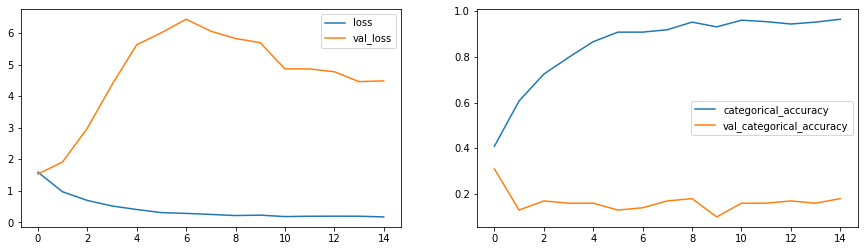

In [ ]:
plot(history)

### Model is highly overfitted

**2nd Experiment -** Finding Perfect Batch size and image dimensions


In [ ]:
BATCH_SIZE=128
model_2nd=define_model()
history=train_model(model_2nd)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_25 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_25 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_39 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_26 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_26 (Activation)  (None, 15, 60, 60, 32)   

# epochs = 15
# channels = 3
# Optimizer = adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  128
image height: 120 image width: 120
img index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
frames from sequence: 30
Epoch 1/15


ResourceExhaustedError: ignored

**Here, Our GPU RAM got crashed. Refer the image below. So we can't go for This Batch size and Image dimensions** .


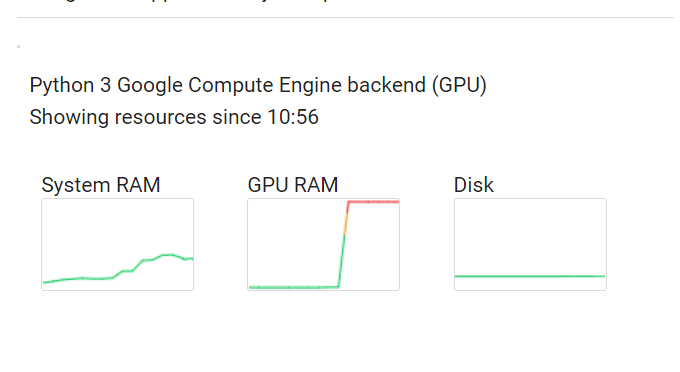

**3rd Experiment -** Finding Perfect Batch size and number of epochs


In [ ]:
#Reduce the Batch Size
BATCH_SIZE=64
image_height=120
image_width=120
NUM_EPOCHS=40
model_3rd= define_model()
history=train_model(model_3rd)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_33 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_51 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_34 (Conv3D)          (None, 15, 60, 60, 32)    4128      
                                                                 
 activation_34 (Activation)  (None, 15, 60, 60, 32)   

# epochs = 40
# channels = 3
# Optimizer = adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  64
image height: 120 image width: 120
img index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
frames from sequence: 30
Epoch 1/40
8/8 [==============================] - ETA: 0s - loss: 1.6509 - categorical_accuracy: 0.4259 Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  64
image height: 120 image width: 120
img index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
frames from sequence: 30

Epoch 1: val_loss improved from inf to 1.59001, saving model to model_3DConv_2022-10-0712_20_00.875741/model-00001-1.65091-0.42589-1.59001-0.24000.h5
8/8 [==============================] - 176s 25s/step - loss: 1.6509 - categorical_accuracy: 0.4259 - val_loss: 1.5900 - val_categorical_accuracy: 0.2400 - lr: 0.

KeyboardInterrupt: ignored

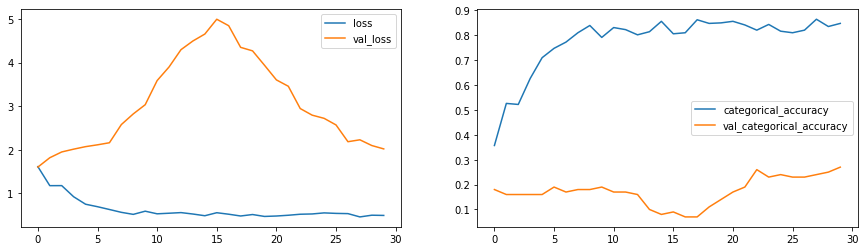

In [ ]:
plot(history)

**4th Experiment -** Reducing size of image and number of frames by using alternate Frames


In [ ]:
#Reduce number of frames
BATCH_SIZE=32
image_height=100
image_width=100
IMG_IDX=list(range(0,30,2)) 
frames_from_seq=len(IMG_IDX)
NUM_EPOCHS=30

model_4th= define_model(FILTERS,KERNEL_SIZE,3)
history=train_model(model_4th)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 15, 100, 100, 16)  1312      
                                                                 
 activation_18 (Activation)  (None, 15, 100, 100, 16)  0         
                                                                 
 batch_normalization_28 (Bat  (None, 15, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 7, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 7, 50, 50, 32)     4128      
                                                                 
 activation_19 (Activation)  (None, 7, 50, 50, 32)    

# epochs = 30
# channels = 3
# Optimizer = adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  32
image height: 100 image width: 100
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15
Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.6127 - categorical_accuracy: 0.3570Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  32
image height: 100 image width: 100
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15

Epoch 1: val_loss improved from inf to 1.60292, saving model to model_3DConv_2022-10-0711_35_22.396266/model-00001-1.61273-0.35699-1.60292-0.18000.h5
15/15 [==============================] - 74s 5s/step - loss: 1.6127 - categorical_accuracy: 0.3570 - val_loss: 1.6029 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 1.1768 - categorical_accuracy: 0.526

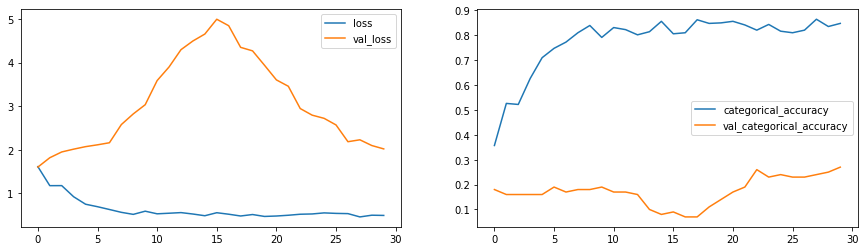

In [ ]:
plot(history)

**Evaluate Model with test data**

In [ ]:
loss_test,accuracy_test= model_4th.evaluate(test_generator,batch_size=BATCH_SIZE)
print("Loss of Test Data is:",loss_test)
print("Accuracy of Tets Data is:",accuracy_test)

**5th Experiment -** Triming frames from beginning and end and also reduce image dimensions to 64 by 64


In [ ]:
#Reduce number of frames by trimming from beginning and end
IMG_IDX=list(range(5,25)) 
frames_from_seq=len(IMG_IDX)
BATCH_SIZE=32
image_height=64
image_width=64
NUM_EPOCHS=15
model_5th= define_model(FILTERS,KERNEL_SIZE,4)
history=train_model(model_5th)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 64, 64, 16)    1312      
                                                                 
 activation (Activation)     (None, 20, 64, 64, 16)    0         
                                                                 
 batch_normalization (BatchN  (None, 20, 64, 64, 16)   64        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 32, 32, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 32, 32, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 10, 32, 32, 32)    0

# epochs = 15
# channels = 3
# Optimizer = Adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  32
image height: 64 image width: 64
img index : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
frames from sequence: 20
Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 1.8557 - categorical_accuracy: 0.3466  Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  32
image height: 64 image width: 64
img index : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
frames from sequence: 20

Epoch 1: val_loss improved from inf to 1.94787, saving model to model_3DConv_2022-10-0804_40_39.150389/model-00001-1.85569-0.34656-1.94787-0.15000.h5
15/15 [==============================] - 2933s 209s/step - loss: 1.8557 - categorical_accuracy: 0.3466 - val_loss: 1.9479 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/15
15/15 [==============================] - ETA: 0s - 

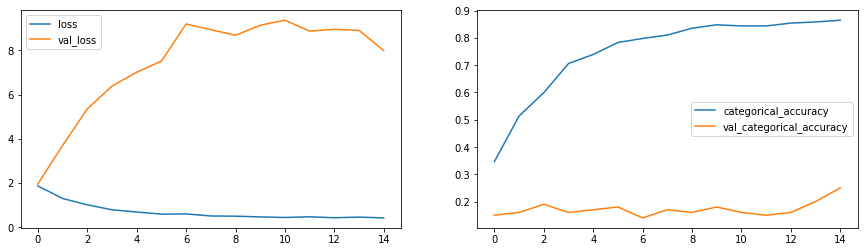

In [ ]:
plot(history)

In [ ]:
loss_test,accuracy_test= model_5th.evaluate(test_generator,batch_size=BATCH_SIZE)
print("Loss of Test Data is:",loss_test)
print("Accuracy of Tets Data is:",accuracy_test)

     41/Unknown - 1181s 30s/step - loss: 8.4503 - categorical_accuracy: 0.2006

**6th Experiment -** Reduce batch size.Reducing size of frames and Taking alternate frames for training. Increasing Number of Epochs


In [ ]:
IMG_IDX=list(range(0,30,2)) 
frames_from_seq=len(IMG_IDX)
BATCH_SIZE=32
image_height=64
image_width=64
NUM_EPOCHS=30

model_6th= define_model(FILTERS,KERNEL_SIZE,3)
history=train_model(model_6th)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 15, 64, 64, 16)    1312      
                                                                 
 activation_15 (Activation)  (None, 15, 64, 64, 16)    0         
                                                                 
 batch_normalization_23 (Bat  (None, 15, 64, 64, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 7, 32, 32, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 7, 32, 32, 32)     4128      
                                                                 
 activation_16 (Activation)  (None, 7, 32, 32, 32)    

# epochs = 30
# channels = 3
# Optimizer = adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  32
image height: 64 image width: 64
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15
Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.7976 - categorical_accuracy: 0.3445Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  32
image height: 64 image width: 64
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15

Epoch 1: val_loss improved from inf to 1.58023, saving model to model_3DConv_2022-10-0710_36_49.836795/model-00001-1.79759-0.34447-1.58023-0.26000.h5
15/15 [==============================] - 74s 5s/step - loss: 1.7976 - categorical_accuracy: 0.3445 - val_loss: 1.5802 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 1.2424 - categorical_accuracy: 0.4969
Ep

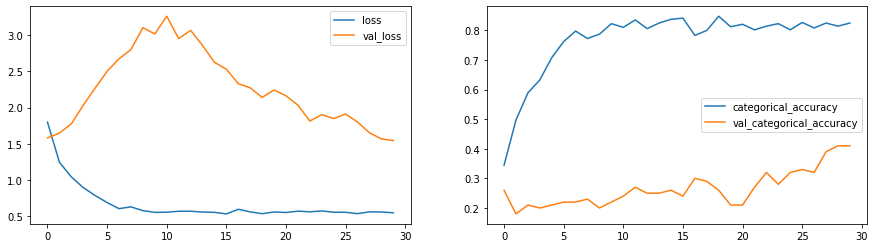

In [ ]:
plot(history)

**Evaluate the model on Test data**


In [ ]:
test_generator = generator(test_path, test_doc)

loss_test,accuracy_test= model_6th.evaluate(test_generator,batch_size=BATCH_SIZE)
print("Loss of Test Data is:",loss_test)
print("Accuracy of Tets Data is:",accuracy_test)

Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  32
image height: 64 image width: 64
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15
    226/Unknown - 4056s 18s/step - loss: 1.6502 - categorical_accuracy: 0.4149

## CNN- LSTM Model /GRU Model

In [72]:
def addTimeDistributed2DConv(model,filters,kernel_size):
  model.add(TimeDistributed(Conv2D(filters, (3,3) , padding='same', activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

def buildRNNModel(filters,kernel_size,num_layers=4,useLSTM=True):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(filters, kernel_size , padding='same', activation='relu'),input_shape=(frames_from_seq,image_height,image_width,CHANNELS)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        for layer in range(1,num_layers):
          filters=2*filters
          addTimeDistributed2DConv(model,filters,kernel_size)
       
        model.add(TimeDistributed(Flatten()))
        
        filters=int(filters/2)
        if(useLSTM):    
          model.add(LSTM(filters))
        else:
          model.add(GRU(filters))
        
        model.add(Dropout(.25))
        
        model.add(Dense(filters,activation='relu'))
        model.add(Dropout(.25))
        
        model.add(Dense(NUM_ClASSES, activation='softmax'))
        optimiser = OPTIMISER
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        #model.build(input_shape=(frames_from_seq,image_height,image_width,CHANNELS))
        model.summary()
        return model
        

**1st Experiment With LSTM-**
Test the model with Default values of parameters to see if model is learning

In [73]:
# Parameters for Generator
BATCH_SIZE=64
image_height=120
image_width=120
IMG_IDX=list(range(0,30,1)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=15
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(3,3)
OPTIMISER="Adam"

In [ ]:
lstm_model_1st=buildRNNModel(FILTERS,KERNEL_SIZE)
history=train_model(lstm_model_1st)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_289 (TimeD  (None, 30, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_290 (TimeD  (None, 30, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_291 (TimeD  (None, 30, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_292 (TimeD  (None, 30, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_293 (TimeD  (None, 30, 60, 60, 32) 

# epochs = 15
# channels = 3
# Optimizer = Adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  64
image height: 120 image width: 120
img index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
frames from sequence: 30
Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 1.6092 - categorical_accuracy: 0.2568  Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  64
image height: 120 image width: 120
img index : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
frames from sequence: 30

Epoch 1: val_loss improved from inf to 1.59958, saving model to model_3DConv_2022-10-0902_10_40.009297/model-00001-1.60924-0.25678-1.59958-0.21000.h5
8/8 [==============================] - 3920s 558s/step - loss: 1.6092 - categorical_accuracy: 0.2568 - val_loss: 1.5996 - val_categorical_accuracy: 0.2100 - lr:

Due to too many training parameters , it is taking too long to train. So, let try to reduce parameters.
1. Reduce image size 
2. Reduce number of frames
3. Reduce number of Time distributed layer from model.

In [74]:
# Parameters for Generator
BATCH_SIZE=64
image_height=100
image_width=100
IMG_IDX=list(range(0,30,2)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=30
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(3,3)
OPTIMISER="Adam"

In [ ]:
lstm_model_2nd=buildRNNModel(FILTERS,KERNEL_SIZE,3)
history=train_model(lstm_model_2nd)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, 15, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 50, 50, 32)  

# epochs = 30
# channels = 3
# Optimizer = Adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  64
image height: 100 image width: 100
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 1.6256 - categorical_accuracy: 0.2422  Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  64
image height: 100 image width: 100
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15

Epoch 1: val_loss improved from inf to 1.58340, saving model to model_3DConv_2022-10-0905_35_31.749894/model-00001-1.62564-0.24217-1.58340-0.17000.h5
8/8 [==============================] - 1975s 280s/step - loss: 1.6256 - categorical_accuracy: 0.2422 - val_loss: 1.5834 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 1.4376 - categorical_accuracy: 0.377

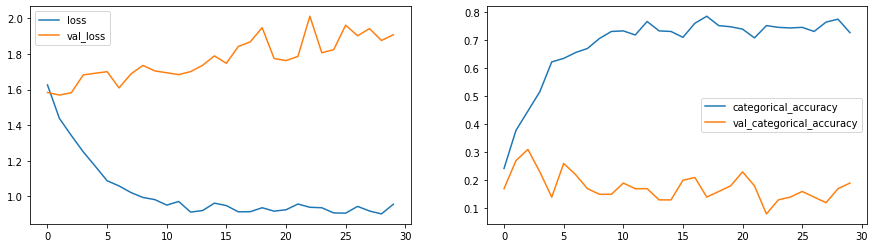

In [ ]:
plot(history)

**Experiment With GRU-**
Build the model with even lesser number of parametrs

In [77]:
# Parameters for Generator
BATCH_SIZE=30
image_height=80
image_width=80
IMG_IDX=list(range(0,30,2)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=30
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(3,3)
OPTIMISER="Adam"

In [78]:
GRU_model_1st=buildRNNModel(FILTERS,KERNEL_SIZE,1,False)
history=train_model(GRU_model_1st)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_51 (TimeDi  (None, 15, 80, 80, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_52 (TimeDi  (None, 15, 80, 80, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_53 (TimeDi  (None, 15, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_54 (TimeDi  (None, 15, 25600)        0         
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 8)                

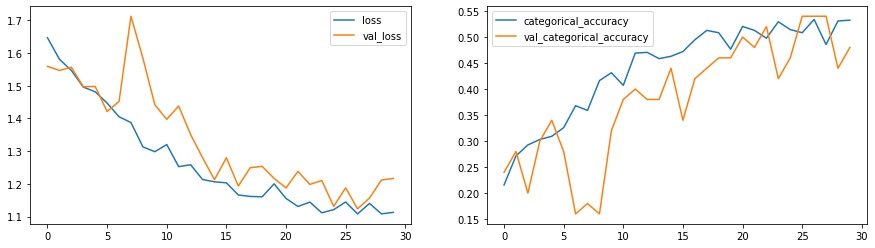

In [79]:
plot(history)

Model Seems learning as Performaing similar on train and validation data.
**Let's increase data points for training**

Seems, model is learning lots of noise and hence, all models are overfitting.
Let's try some **data augmentation**

In [80]:
import cv2

In [81]:
def prepare_Aug_batch(source,t,this_batch,extra_items=0):
  img_idx=IMG_IDX
  batch_size=BATCH_SIZE
  seqlen = extra_items if extra_items !=0 else batch_size
  #print("For debug-Seqlen:",seqlen)

  batch_data = np.zeros((seqlen,len(img_idx),image_height,image_width,CHANNELS))                    # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
  batch_labels = np.zeros((seqlen,NUM_ClASSES))                                                        # batch_labels is the one hot representation of the output. this is because in batch labels 4,3,2 ,1,0, model tend to give more importance to label 4
  batch_data_aug = np.zeros((seqlen,len(img_idx),image_height,image_width,CHANNELS))
  for folder in range(seqlen):
    imgs = sorted(os.listdir(source+'/'+ t[folder + (this_batch*batch_size)].split(';')[0])) # The csv file is ; separated.Order of images matters for identifying the action
    for idx,item in enumerate(img_idx):
       image = imread(source+'/'+ t[folder + (this_batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
      
      
       image=resize(image,(image_height,image_width) )
       
       batch_data[folder,idx,:,:,0] = (image[:,:,0])/255                                       #Resizing Channel 1 of image (As it is RGB Image)
       batch_data[folder,idx,:,:,1] = (image[:,:,1])/255                                       #Resizing Channel 2 of image (As it is RGB Image)
       batch_data[folder,idx,:,:,2] = (image[:,:,2])/255                                       #Resizing Channel 3 of image (As it is RGB Image)
      #Perform Augmentation
       shifted = cv2.warpAffine(image,np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), #Perform wrapaffin transformation 
                                            (image.shape[1], image.shape[0]))
                    
       gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)                                          #convert part of image from one color space to another
       x0, y0 = np.argwhere(gray > 0).min(axis=0)
       x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
       cropped=shifted[x0:x1,y0:y1,:]                                                          #Crop image to remove Grey area
                    
       image_resized=resize(cropped,(image_height,image_width,3))                              #Resize image to mentioned dimensions
                    
       M = cv2.getRotationMatrix2D((image_width//2,image_height//2),
                                                np.random.randint(-10,10), 1.0)
       rotated = cv2.warpAffine(image_resized, M, (image_width,image_height))
  
       batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
       batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
       batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
    
    batch_labels[folder, int(t[folder + (this_batch*batch_size)].strip().split(';')[2])] = 1    
 
  batch_data=np.concatenate([batch_data,batch_data_aug])
  batch_labels=np.concatenate([batch_labels,batch_labels])
  return batch_data,batch_labels


def generator_aug(source_path, folder_list):
    batch_size=BATCH_SIZE
    print( 'Source path = ', source_path)
    display_generator_params()
    while True:
        t = np.random.permutation(folder_list)           # Choose folder list in random order
        num_batches =len(t) // batch_size                # Calculate the number of required batches
        #print("For debug-Number of batches:",num_batches)
        for batch in range(num_batches):                 # Iterate over batches
            #print("For debug-batch:",batch)
            batch_data, batch_labels= prepare_Aug_batch(source_path,t,batch,0)
            yield batch_data, batch_labels               # You yield the batch_data and the batch_labels
        
        extra=len(t)%batch_size                          # Get the remaining items that could not make a full batch   
        #print("For debug-Extra:",extra)
        if extra != 0:
          batch_data, batch_labels= prepare_Aug_batch(source_path,t,batch,extra)
          yield batch_data, batch_labels

In [82]:
def train_model_aug(model):
        
        model_name = 'model_3DConv' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        #earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint,LR]

        if (num_train_sequences%BATCH_SIZE) == 0:
            steps_per_epoch = int(num_train_sequences/BATCH_SIZE)
        else:
            steps_per_epoch = (num_train_sequences//BATCH_SIZE) + 1

        if (num_val_sequences%BATCH_SIZE) == 0:
            validation_steps = int(num_val_sequences/BATCH_SIZE)
        else:
            validation_steps = (num_val_sequences//BATCH_SIZE) + 1
        
        train_generator = generator_aug(train_path, train_doc)
        val_generator = generator_aug(val_path,val_doc)
        display_model_params()
        history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


### Let's build and train model with Augmented data

In [83]:
### Parameters for Generator
BATCH_SIZE=30
image_height=120
image_width=120
IMG_IDX=list(range(0,30,2)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=30
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(3,3)
OPTIMISER="Adam"

In [ ]:
GRU_model_2nd=buildRNNModel(FILTERS,KERNEL_SIZE,1,False)
history=train_model_aug(GRU_model_2nd)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 57600)        0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 8)                

# epochs = 40
# channels = 3
# Optimizer = Adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  64
image height: 120 image width: 120
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15
Epoch 1/40
8/8 [==============================] - ETA: 0s - loss: 1.6210 - categorical_accuracy: 0.2380  Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  64
image height: 120 image width: 120
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15

Epoch 1: val_loss improved from inf to 1.69739, saving model to model_3DConv_2022-10-0915_06_20.875935/model-00001-1.62103-0.23800-1.69739-0.29500.h5
8/8 [==============================] - 2295s 326s/step - loss: 1.6210 - categorical_accuracy: 0.2380 - val_loss: 1.6974 - val_categorical_accuracy: 0.2950 - lr: 0.0010
Epoch 2/40
8/8 [==============================] - ETA: 0s - loss: 1.5816 - categorical_accuracy: 0.273

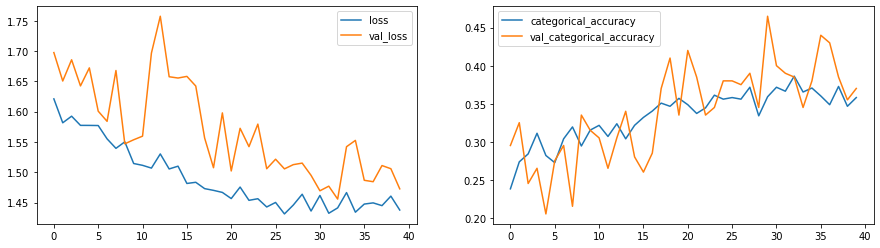

In [ ]:
plot(history)

**Let's increase the number of Time distributed layers in CNN+GRU**

In [ ]:
image_height=120
image_width=120
BATCH_SIZE=20
IMG_IDX=list(range(1,19)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=30
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(3,3)
OPTIMISER="Adam"
GRU_model_3rd=buildRNNModel(FILTERS,KERNEL_SIZE,4,False)
history=train_model_aug(GRU_model_3rd)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 18, 60, 60, 32)  

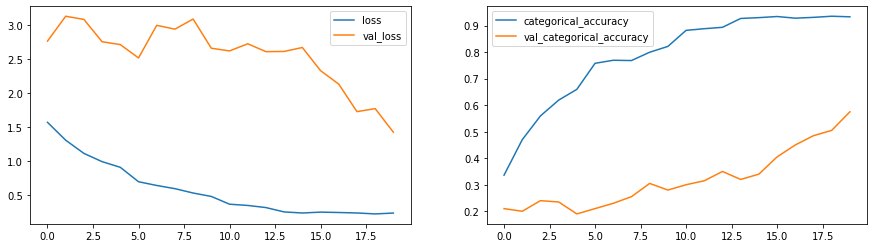

In [ ]:
plot(history)

Let's increase epochs tp 50

In [ ]:
image_height=120
image_width=120
BATCH_SIZE=20
IMG_IDX=list(range(1,19)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=50
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(3,3)
OPTIMISER="Adam"
GRU_model_3rd=buildRNNModel(FILTERS,KERNEL_SIZE,4,False)
history=train_model_aug(GRU_model_3rd)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)   1

# epochs = 50
# channels = 3
# Optimizer = Adam
Source path =  /content/drive/MyDrive/GestureData/Project_data/train
Batch Size :  20
image height: 120 image width: 120
img index : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
frames from sequence: 18
Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.6216 - categorical_accuracy: 0.3006Source path =  /content/drive/MyDrive/GestureData/Project_data/val
Batch Size :  20
image height: 120 image width: 120
img index : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
frames from sequence: 18

Epoch 1: val_loss improved from inf to 2.04640, saving model to model_3DConv_2022-10-0920_14_29.950039/model-00001-1.62160-0.30063-2.04640-0.18000.h5
24/24 [==============================] - 142s 6s/step - loss: 1.6216 - categorical_accuracy: 0.3006 - val_loss: 2.0464 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.3391 - categorica

### Let Use Alternate frames for training

In [28]:
image_height=100
image_width=100
BATCH_SIZE=30
IMG_IDX=list(range(0,30,2)) 
frames_from_seq=len(IMG_IDX)

NUM_ClASSES=5
NUM_EPOCHS=30
CHANNELS=3
FILTERS=16
KERNEL_SIZE=(3,3)

OPTIMISER = tf.keras.optimizers.Adam() 

GRU_model_4th=buildRNNModel(FILTERS,KERNEL_SIZE,4,False)
history=train_model_aug(GRU_model_4th)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 15, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 15, 100, 100, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 15, 50, 50, 32)  

2022-10-11 02:55:51.011827: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.4811 - categorical_accuracy: 0.3439Source path =  /datasets/Project_data/val
Batch Size :  30
image height: 100 image width: 100
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15

Epoch 00001: val_loss improved from inf to 1.70278, saving model to model_3DConv_2022-10-1102_55_42.494951/model-00001-1.48114-0.34389-1.70278-0.34000.h5
23/23 [==============================] - 116s 5s/step - loss: 1.4811 - categorical_accuracy: 0.3439 - val_loss: 1.7028 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.1986 - categorical_accuracy: 0.5211
Epoch 00002: val_loss did not improve from 1.70278
23/23 [==============================] - 104s 5s/step - loss: 1.1986 - categorical_accuracy: 0.5211 - val_loss: 1.8759 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.108

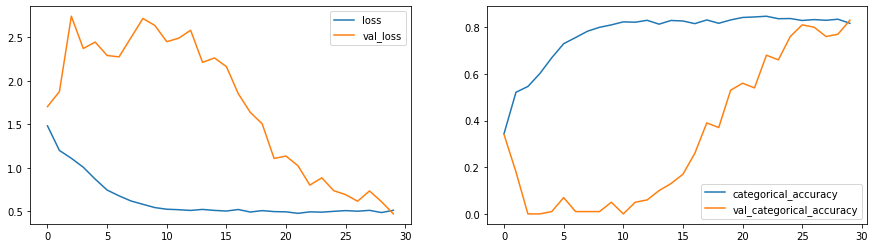

In [29]:
plot(history)

In [33]:
test_generator = generator_aug(test_path, test_doc)

loss_test,accuracy_test= GRU_model_4th.evaluate(test_generator,batch_size=BATCH_SIZE)
print("Loss of Test Data is:",loss_test)
print("Accuracy of Tets Data is:",accuracy_test)

Source path =  /datasets/Project_data/val
Batch Size :  30
image height: 100 image width: 100
img index : [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
frames from sequence: 15
    330/Unknown - 1479s 4s/step - loss: 0.5451 - categorical_accuracy: 0.8349

## So our Final Model is GRU_model_4th with Train accuracy=0.82 and Validation accuracy =0.83 and Test Accuracy =83
#### Details of Final Model:
##### Total train data available in Train.csv have been used for training the model
##### The Validation data has been splitted into 2 halves , one for validation and other half is used for calculating test accuracy
##### Parameters for generator are:

- image_height=100
- image_width=100
- BATCH_SIZE=30
- IMG_IDX=[0,2,4,6,8,10,12,14,16,18,20,22,24,26,28] i.e. Alternate frame has been used for training. Hence number of frames in a sequence is 15
- For the final model Generator with Augmentation has been used where we have performed some wrapaffine transformation, cropping and restoring to specified size

##### Parameters for Model training are:
- NUM_EPOCHS=30
- CHANNELS=3
- FILTERS=16
- KERNEL_SIZE=(3,3)

##### Model Architecture is
- **CNN+ GRU** with Total params: 1,000,293 and **Trainable params: 999,813** and Non-trainable params: 480

#### Below is the Architecture of Final Model

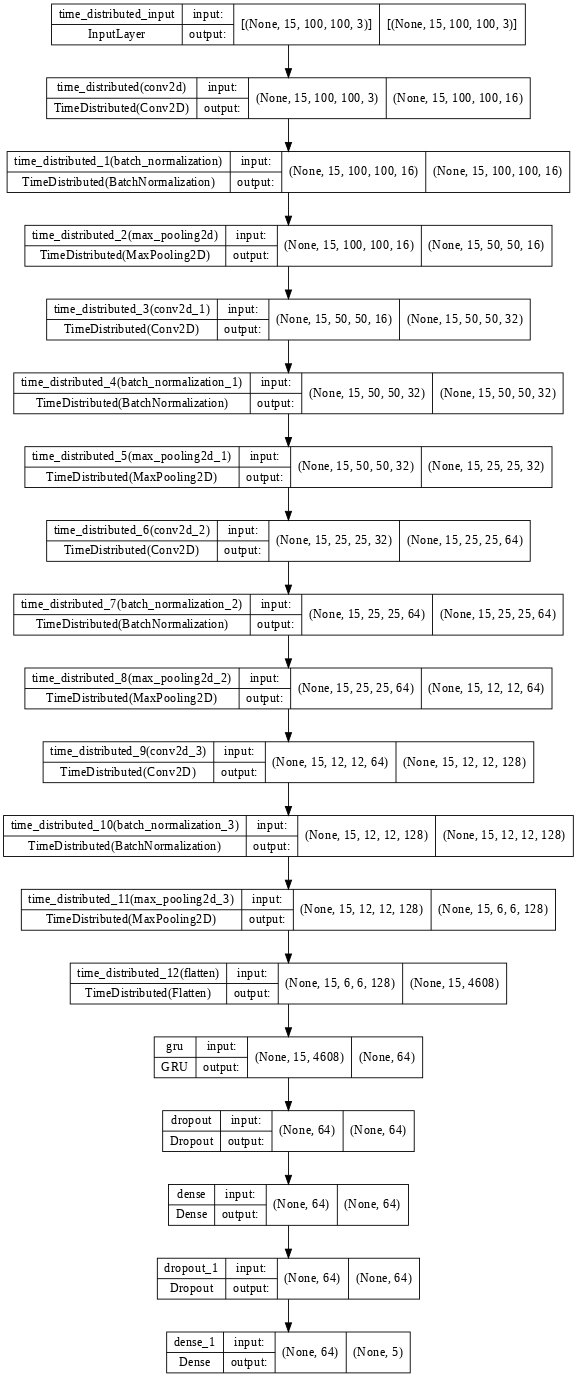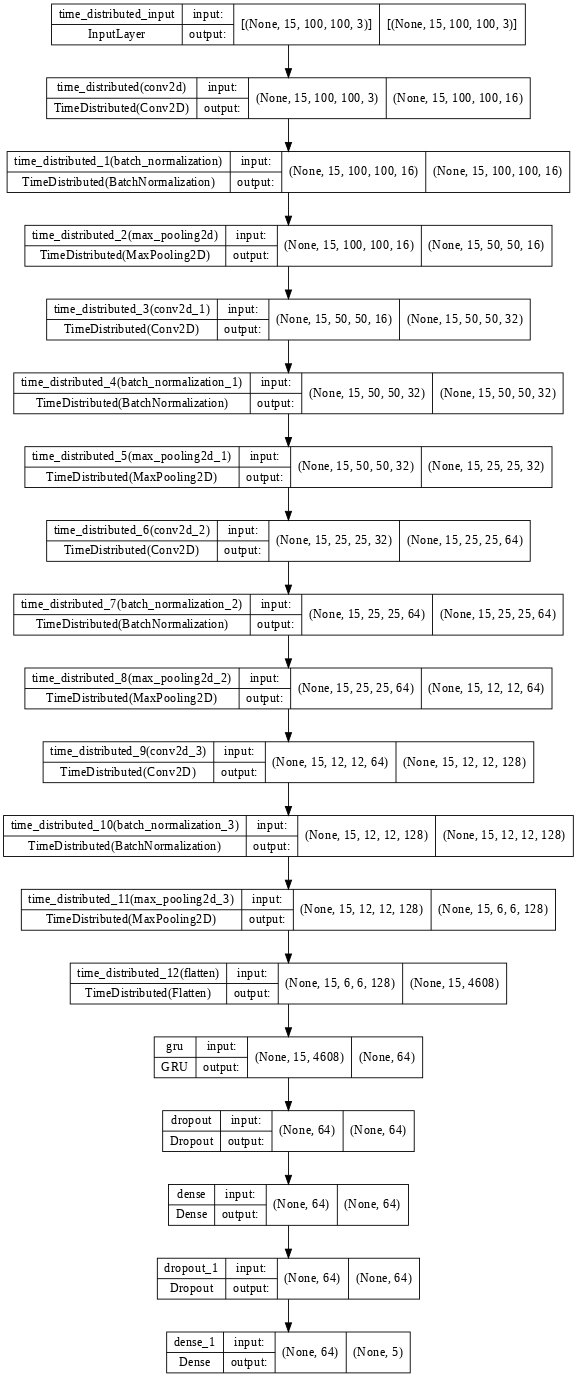

#### NOTE:=> SOME PART of the notebook have been executed on Google Colab and Some on Jarvis Lab platform.